In [ ]:
# %%
# open a file as csv without header

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,natsort
import natsort


In [ ]:
vary_batchsize_gpus_target_dir = '/mydata/pytorch_custom_log_one_epoch_imagenet_dataset'
vary_dataloaders_target_dir = '/mydata/pytorch_custom_log_and_vtune_one_epoch_imagenet_dataset'


In [ ]:
for root, dirs, files in os.walk(vary_batchsize_gpus_target_dir):
    print(root,dirs,files)


In [76]:
def preprocessing_time_summary_vary_batchsize_gpus(target_dir,sort_by='batch_id',fig_size=(50,25),remove_outliers=True,fig_prefix='',fig_dir=''):
    
    root_to_files = {}
    for root, dirs, files in os.walk(target_dir):
        root_to_files[root] = files
    roots = sorted(root_to_files, key=lambda x: natsort.natsort_key(x.lower()))

    e2e_stat_dir = None
    for root in root_to_files:
        if 'e2e' in root:
            e2e_stat_dir = root

    total_job_elapsed_time = {}
    print("Fetching E2E job time")
    for file in root_to_files[e2e_stat_dir]:

        label = file.split('/')[-1].split('custom_log_')[1].split('.log')[0] # retrieves custom_log_b1024_gpu2.log kind of label
        print(f"{label}:")
        print(os.path.join(e2e_stat_dir, file))
        # read file as csv
        df = pd.read_csv(os.path.join(e2e_stat_dir, file))
        # cast wall(s) column as float type
        df['wall(s)'] = df['wall(s)'].astype(float)
        print(df['wall(s)'][0])
        total_job_elapsed_time[label] = df['wall(s)'][0]
        
    OOO_percentage_combined_df = {}

    total_wait_percentage_combined_df = {}
    for root in roots:
        if 'e2e' in root:
            continue
        print(root)
        files = root_to_files[root]

        OOO_percentage = None
        total_wait = None
        
        for file in files:
            if "main_pid" not in file:
                continue

            df = pd.read_csv(os.path.join(root, file)
                            , header=None)

            # add header
            df.columns = ['name','start_ts','duration']

            # names that start with 'SBatchWait'
            df = df[df['name'].str.startswith('SBatchWait')]
            # map 'SBatchPreprocessed_' such that 'SBatchWait_idx' becomes 'idx' where idx is an integer
            df['batch_id'] = df['name'].map(lambda x: int(x.replace('SBatchWait_','')))

            # total duration of wait time
            total_wait = df["duration"].sum()/1000/1000/1000
            print(f'Total wait time (s): {total_wait}')
            


            # divide by 1000000 to convert from nanoseconds to microseconds
            df['duration'] = df['duration']/1000

            # Total OOO batches (1 microsecond wait time)
            print(f'Total OOO batches: {df[df["duration"]==1].shape[0]}')
            # Total batches
            print(f'total batches: {df.shape[0]}')

            OOO_percentage = df[df["duration"]==1].shape[0] / df.shape[0] * 100


            print(f'OOO percentage: {OOO_percentage}%')
        
        if OOO_percentage is None:
            continue

        label = root.split('/')[-1] # retrieves b128_gpu4 kind of label
        print(f'{label}:')
        OOO_percentage_combined_df[label] = OOO_percentage
        total_wait_percentage_combined_df[label] = total_wait/total_job_elapsed_time[label] * 100


    df = pd.DataFrame.from_dict(OOO_percentage_combined_df,orient='index',columns=['OOO_percentage'])
    # natsort the index
    df = df.reindex(natsort.natsorted(df.index))
    print(df)
    # plot the dataframe
    df.plot(kind='bar')
    # remove legend
    plt.legend().remove()
    # add x and y labels
    plt.xlabel('Configurations')
    plt.ylabel('OOO batches Percentage (%)')
    # put number on top of bars
    for i, v in enumerate(df['OOO_percentage']):
        plt.text(i, v + 0.5, str(round(v,2)), ha='center')
    plt.show()

    df = pd.DataFrame.from_dict(total_wait_percentage_combined_df,orient='index',columns=['stall_percentage'])
    # natsort the index
    df = df.reindex(natsort.natsorted(df.index))
    print(df)
    # plot the dataframe
    df.plot(kind='bar',figsize=(10,3))
    # remove legend
    plt.legend().remove()
    # add x and y labels
    plt.xlabel('Configurations')
    plt.ylabel('E2E Stall (%)')
    # put number on top of bars
    for i, v in enumerate(df['stall_percentage']):
        plt.text(i, v + 0.5, str(round(v,2)), ha='center')
    plt.show()

    return


Fetching E2E job time
b512_gpu3:
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/e2e/custom_log_b512_gpu3.log
2940.4
b1024_gpu4:
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/e2e/custom_log_b1024_gpu4.log
2315.4
b256_gpu1:
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/e2e/custom_log_b256_gpu1.log
8810.62
b1024_gpu2:
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/e2e/custom_log_b1024_gpu2.log
4371.88
b128_gpu1:
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/e2e/custom_log_b128_gpu1.log
8886.22
b512_gpu2:
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/e2e/custom_log_b512_gpu2.log
4351.37
b128_gpu3:
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/e2e/custom_log_b128_gpu3.log
2954.18
b128_gpu2:
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/e2e/custom_log_b128_gpu2.log
4442.63
b512_gpu4:
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/e2e/custom_log_b512_gpu4.log
2290.21
b256_gpu3:
/mydata/pytorch_custom_log_one_epoch_imagenet_d

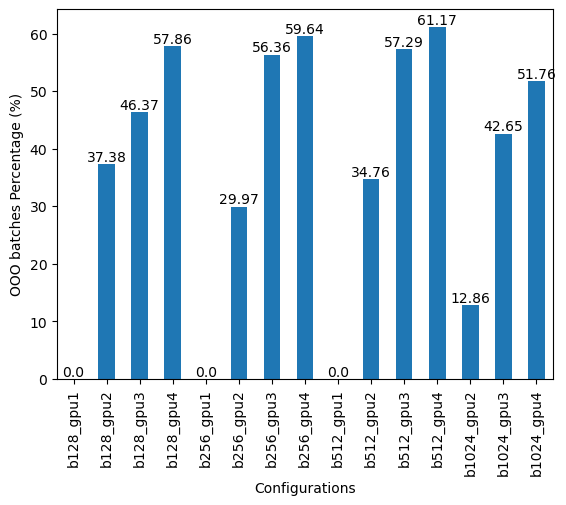

            stall_percentage
b128_gpu1          93.910194
b128_gpu2          87.602993
b128_gpu3          83.122010
b128_gpu4          78.259064
b256_gpu1          94.474198
b256_gpu2          89.517669
b256_gpu3          85.302795
b256_gpu4          82.167893
b512_gpu1          94.610985
b512_gpu2          89.950556
b512_gpu3          85.976782
b512_gpu4          83.225562
b1024_gpu2         91.650248
b1024_gpu3         87.339970
b1024_gpu4         84.286204


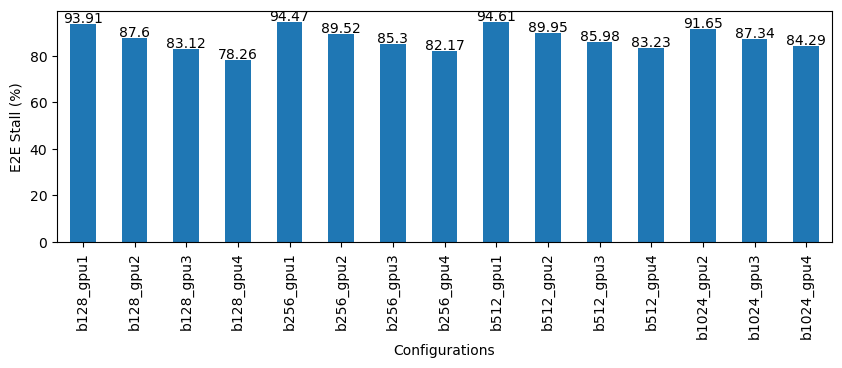

In [77]:
preprocessing_time_summary_vary_batchsize_gpus(vary_batchsize_gpus_target_dir)

In [100]:
def preprocessing_time_summary_vary_dataloaders(target_dir,sort_by='batch_id',fig_size=(50,25),remove_outliers=True,fig_prefix='',fig_dir=''):
    
    root_to_files = {}
    for root, dirs, files in os.walk(target_dir):
        root_to_files[root] = files
    roots = sorted(root_to_files, key=lambda x: natsort.natsort_key(x.lower()))

    e2e_stat_dir = None
    for root in root_to_files:
        if 'e2e' in root:
            e2e_stat_dir = root

    total_job_elapsed_time = {}
    print("Fetching E2E job time")
    for file in root_to_files[e2e_stat_dir]:

        label = file.split('/')[-1].split('custom_log_')[1].split('.log')[0] # retrieves custom_log_b1024_gpu2.log kind of label
        print(f"{label}:")
        print(os.path.join(e2e_stat_dir, file))
        # read file as csv
        df = pd.read_csv(os.path.join(e2e_stat_dir, file),nrows=3)
        # cast wall(s) column as float type
        df['Metric Value'] = df['Metric Value'].astype(float)
        job_elapsed_time = df[df["Metric Name"]=="Elapsed Time"]["Metric Value"][0]
        print(f"Elapsed Time(s): {job_elapsed_time}")
        total_job_elapsed_time[label] = job_elapsed_time
        
    OOO_percentage_combined_df = {}

    total_wait_percentage_combined_df = {}
    for root in roots:
        if 'e2e' in root:
            continue
        print(root)
        files = root_to_files[root]

        OOO_percentage = None
        total_wait = None
        
        for file in files:
            if "main_pid" not in file:
                continue

            df = pd.read_csv(os.path.join(root, file)
                            , header=None)

            # add header
            df.columns = ['name','start_ts','duration']

            # names that start with 'SBatchWait'
            df = df[df['name'].str.startswith('SBatchWait')]
            # map 'SBatchPreprocessed_' such that 'SBatchWait_idx' becomes 'idx' where idx is an integer
            df['batch_id'] = df['name'].map(lambda x: int(x.replace('SBatchWait_','')))

            # total duration of wait time
            total_wait = df["duration"].sum()/1000/1000/1000
            print(f'Total wait time (s): {total_wait}')
            


            # divide by 1000000 to convert from nanoseconds to microseconds
            df['duration'] = df['duration']/1000

            # Total OOO batches (1 microsecond wait time)
            print(f'Total OOO batches: {df[df["duration"]==1].shape[0]}')
            # Total batches
            print(f'total batches: {df.shape[0]}')

            OOO_percentage = df[df["duration"]==1].shape[0] / df.shape[0] * 100


            print(f'OOO percentage: {OOO_percentage}%')
        
        if OOO_percentage is None:
            continue

        label = root.split('/')[-1] # retrieves b128_gpu4 kind of label
        print(f'{label}:')
        OOO_percentage_combined_df[label] = OOO_percentage
        total_wait_percentage_combined_df[label] = total_wait/total_job_elapsed_time[label] * 100


    df = pd.DataFrame.from_dict(OOO_percentage_combined_df,orient='index',columns=['OOO_percentage'])
    # natsort the index
    df = df.reindex(natsort.natsorted(df.index))
    print(df)
    # plot the dataframe
    df.plot(kind='bar')
    # remove legend
    plt.legend().remove()
    # add x and y labels
    plt.xlabel('Configurations')
    plt.ylabel('OOO batches Percentage (%)')
    # put number on top of bars
    for i, v in enumerate(df['OOO_percentage']):
        plt.text(i, v + 0.5, str(round(v,2)), ha='center')
    plt.show()

    df = pd.DataFrame.from_dict(total_wait_percentage_combined_df,orient='index',columns=['stall_percentage'])
    # natsort the index
    df = df.reindex(natsort.natsorted(df.index))
    print(df)
    # plot the dataframe
    df.plot(kind='bar')
    # remove legend
    plt.legend().remove()
    # add x and y labels
    plt.xlabel('Configurations')
    plt.ylabel('E2E Stall (%)')
    # put number on top of bars
    for i, v in enumerate(df['stall_percentage']):
        plt.text(i, v + 0.5, str(round(v,2)), ha='center')
    plt.show()

    return


Fetching E2E job time
b1024_gpu4_dataloader28:
/mydata/pytorch_custom_log_and_vtune_one_epoch_imagenet_dataset/e2e/custom_log_b1024_gpu4_dataloader28.log
Elapsed Time(s): 635.569072
b1024_gpu4_dataloader20:
/mydata/pytorch_custom_log_and_vtune_one_epoch_imagenet_dataset/e2e/custom_log_b1024_gpu4_dataloader20.log
Elapsed Time(s): 688.914998
b1024_gpu4_dataloader12:
/mydata/pytorch_custom_log_and_vtune_one_epoch_imagenet_dataset/e2e/custom_log_b1024_gpu4_dataloader12.log
Elapsed Time(s): 903.619527
b1024_gpu4_dataloader24:
/mydata/pytorch_custom_log_and_vtune_one_epoch_imagenet_dataset/e2e/custom_log_b1024_gpu4_dataloader24.log
Elapsed Time(s): 650.581606
b1024_gpu4_dataloader8:
/mydata/pytorch_custom_log_and_vtune_one_epoch_imagenet_dataset/e2e/custom_log_b1024_gpu4_dataloader8.log
Elapsed Time(s): 1280.772053
b1024_gpu4_dataloader16:
/mydata/pytorch_custom_log_and_vtune_one_epoch_imagenet_dataset/e2e/custom_log_b1024_gpu4_dataloader16.log
Elapsed Time(s): 734.823476
/mydata/pytorch_cus

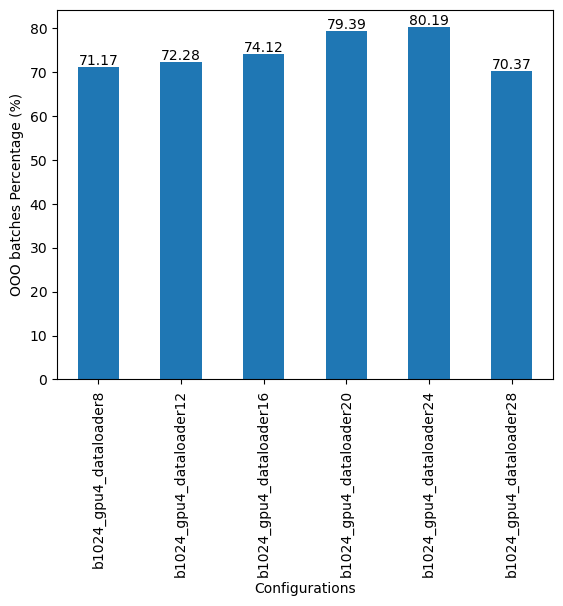

                         stall_percentage
b1024_gpu4_dataloader8          69.346985
b1024_gpu4_dataloader12         55.548327
b1024_gpu4_dataloader16         43.558475
b1024_gpu4_dataloader20         38.684664
b1024_gpu4_dataloader24         33.468550
b1024_gpu4_dataloader28         31.554155


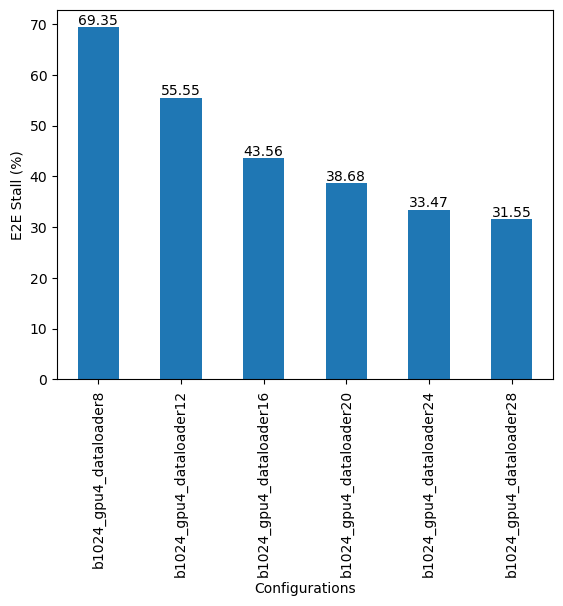

In [101]:
preprocessing_time_summary_vary_dataloaders(vary_dataloaders_target_dir)